In [1]:
from function.function import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from pandas.core import datetools

import warnings

warnings.filterwarnings('ignore')
get_ipython().magic('matplotlib inline')

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1.EDA

### 1-1 데이터 소개

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [ ]:
print("Train data : ", train.shape)
print("Test  data : ", test.shape)

In [ ]:
train.tail()

In [ ]:
test.tail()

In [ ]:
train.describe()

Find : 1. LotFrontage, MasVnrArea 등 일부 데이터가 missing되었음

### 1-2 타겟 데이터 (SalePrice)

In [ ]:
train["SalePrice"].describe()

In [ ]:
plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(train["SalePrice"])

plt.subplot(132)
stats.probplot(train["SalePrice"], plot=plt)

plt.subplot(133)
sns.boxplot(train["SalePrice"])
plt.tight_layout()
plt.show()

### 1-3  Analysis the univariance

In [ ]:
# train = train.iloc[:,1:] #Id열 제거
train["MSSubClass"] = train["MSSubClass"].astype('str')   

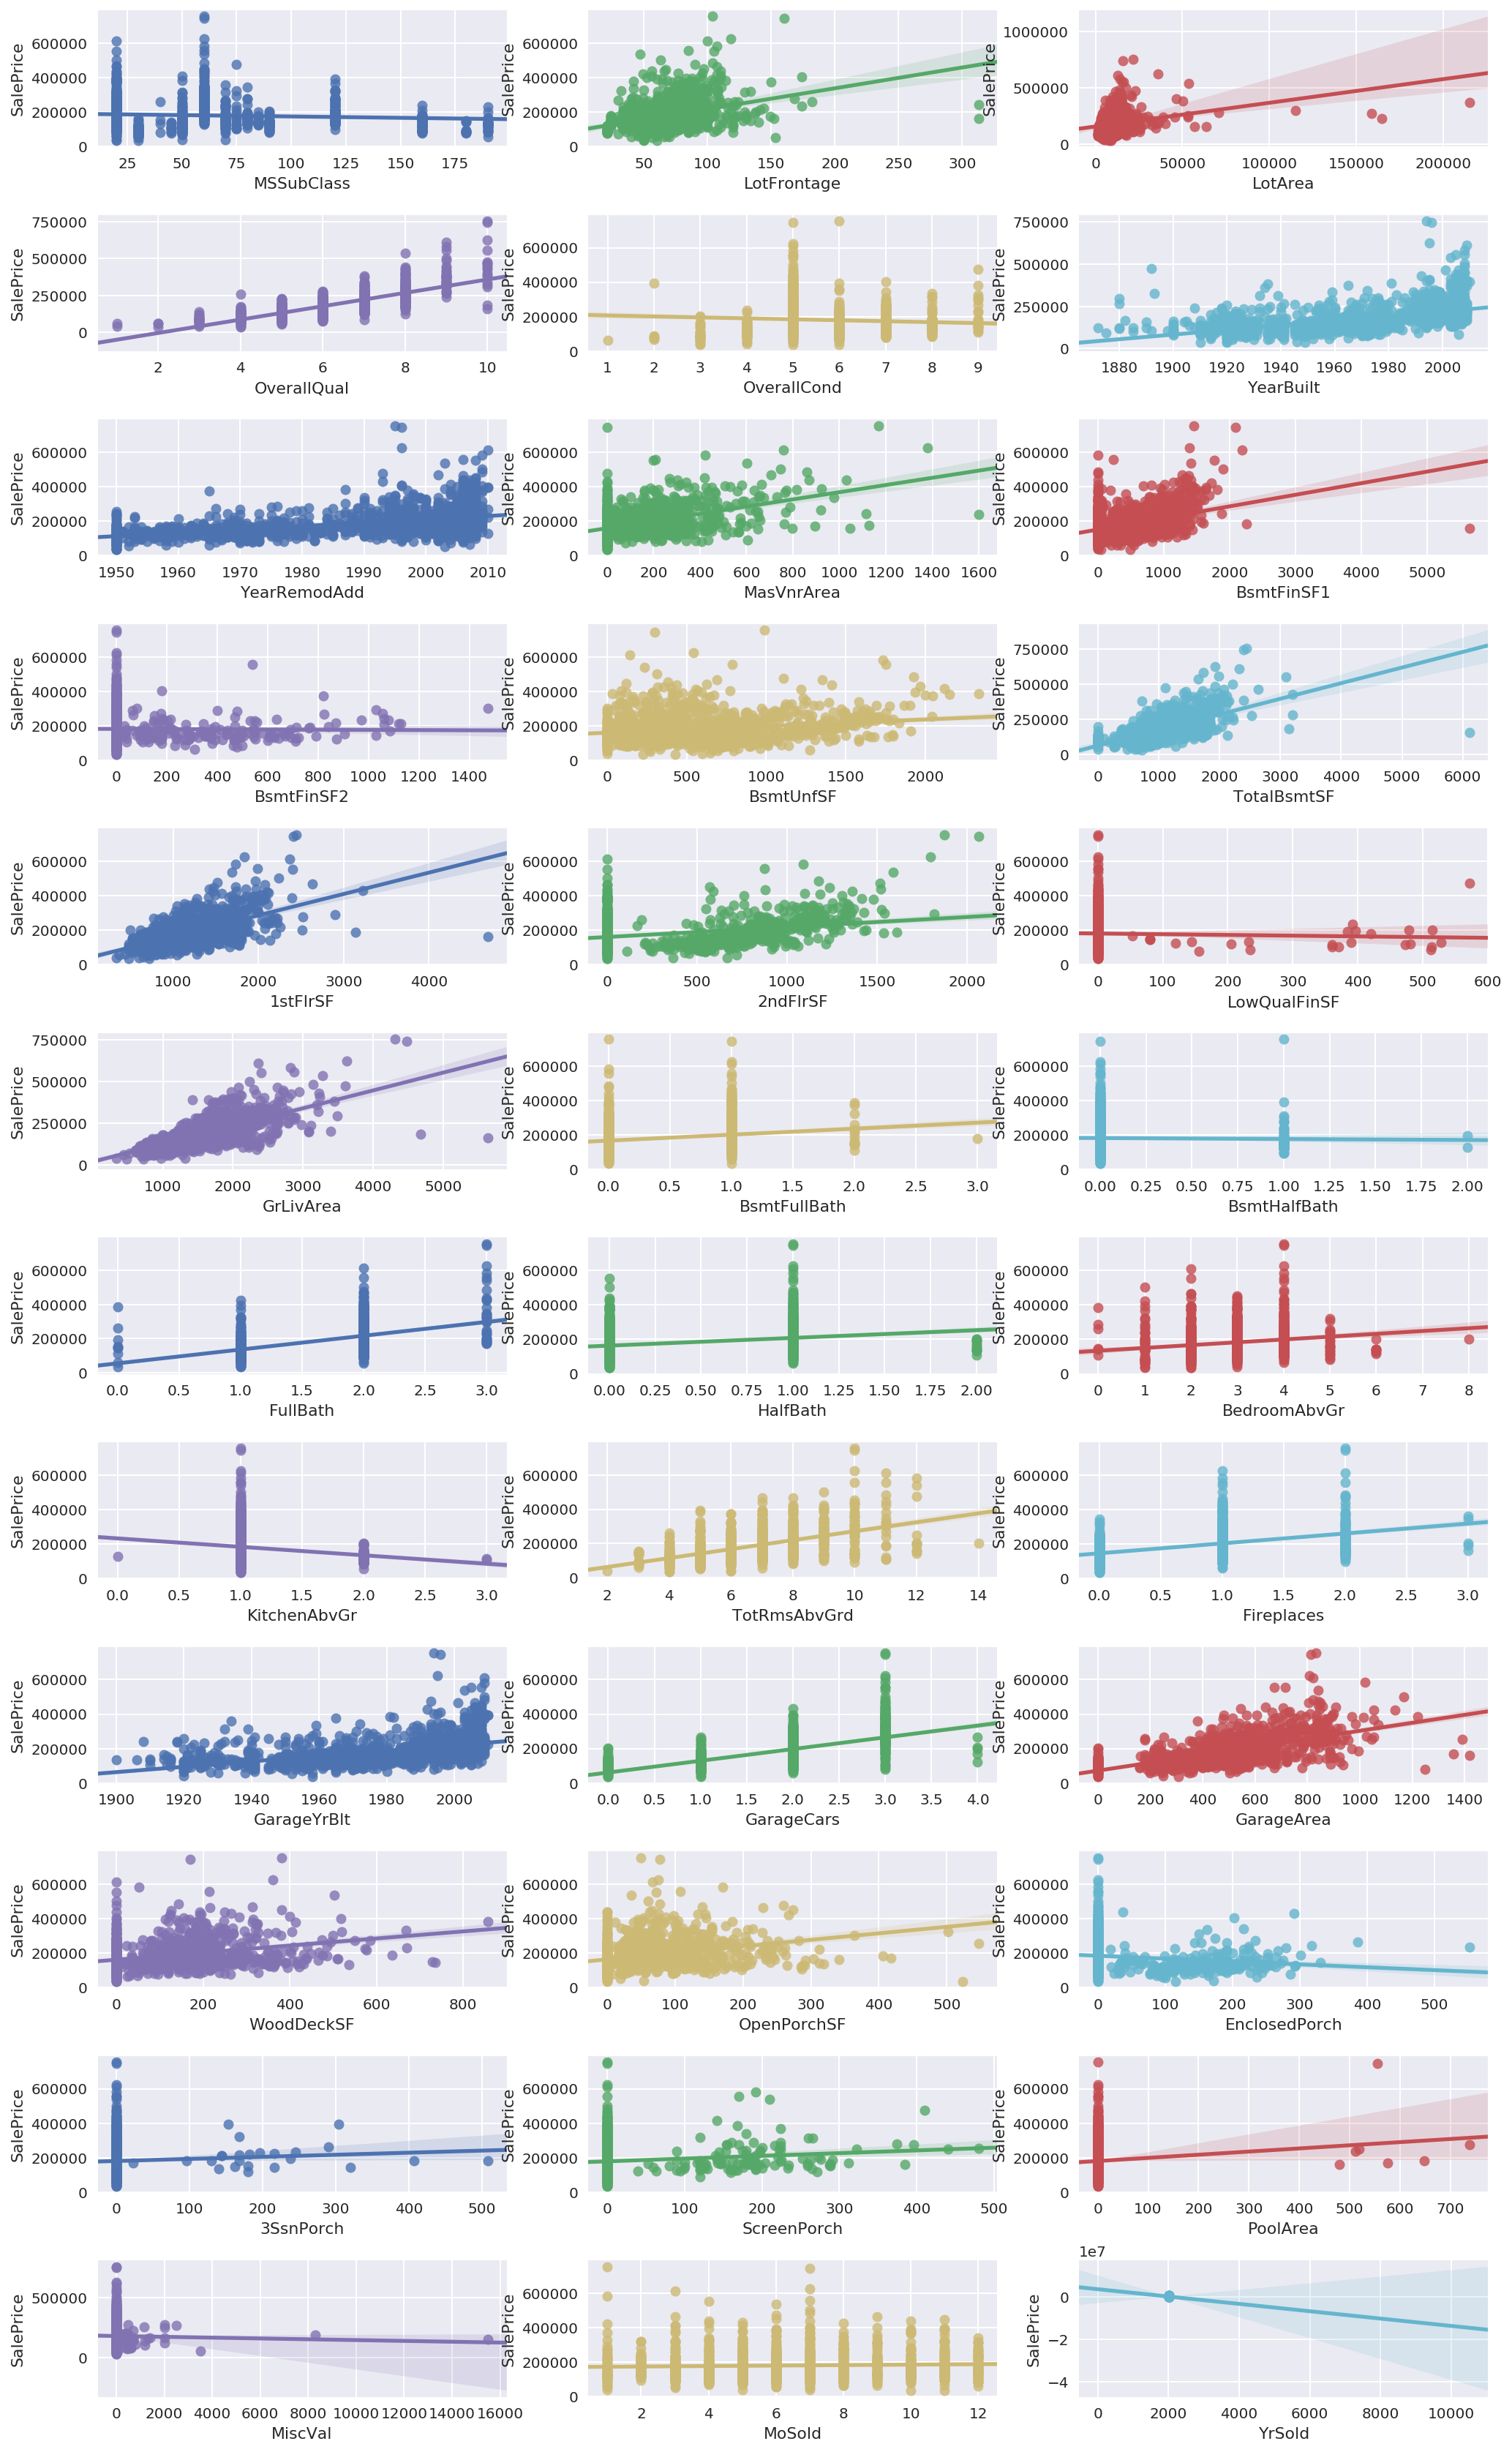

In [7]:
train_num = train.select_dtypes(include=[np.number])
train_num = train_num.drop(['Id'], axis=1)

fig, axs = plt.subplots(12,3, figsize=(16, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2, right=0.95)

axs = axs.ravel()

for ind, feat in enumerate(train_num.columns):
    if feat != 'SalePrice':
        sns.regplot(train_num[feat], train_num['SalePrice'], ax = axs[ind])
    
plt.show()


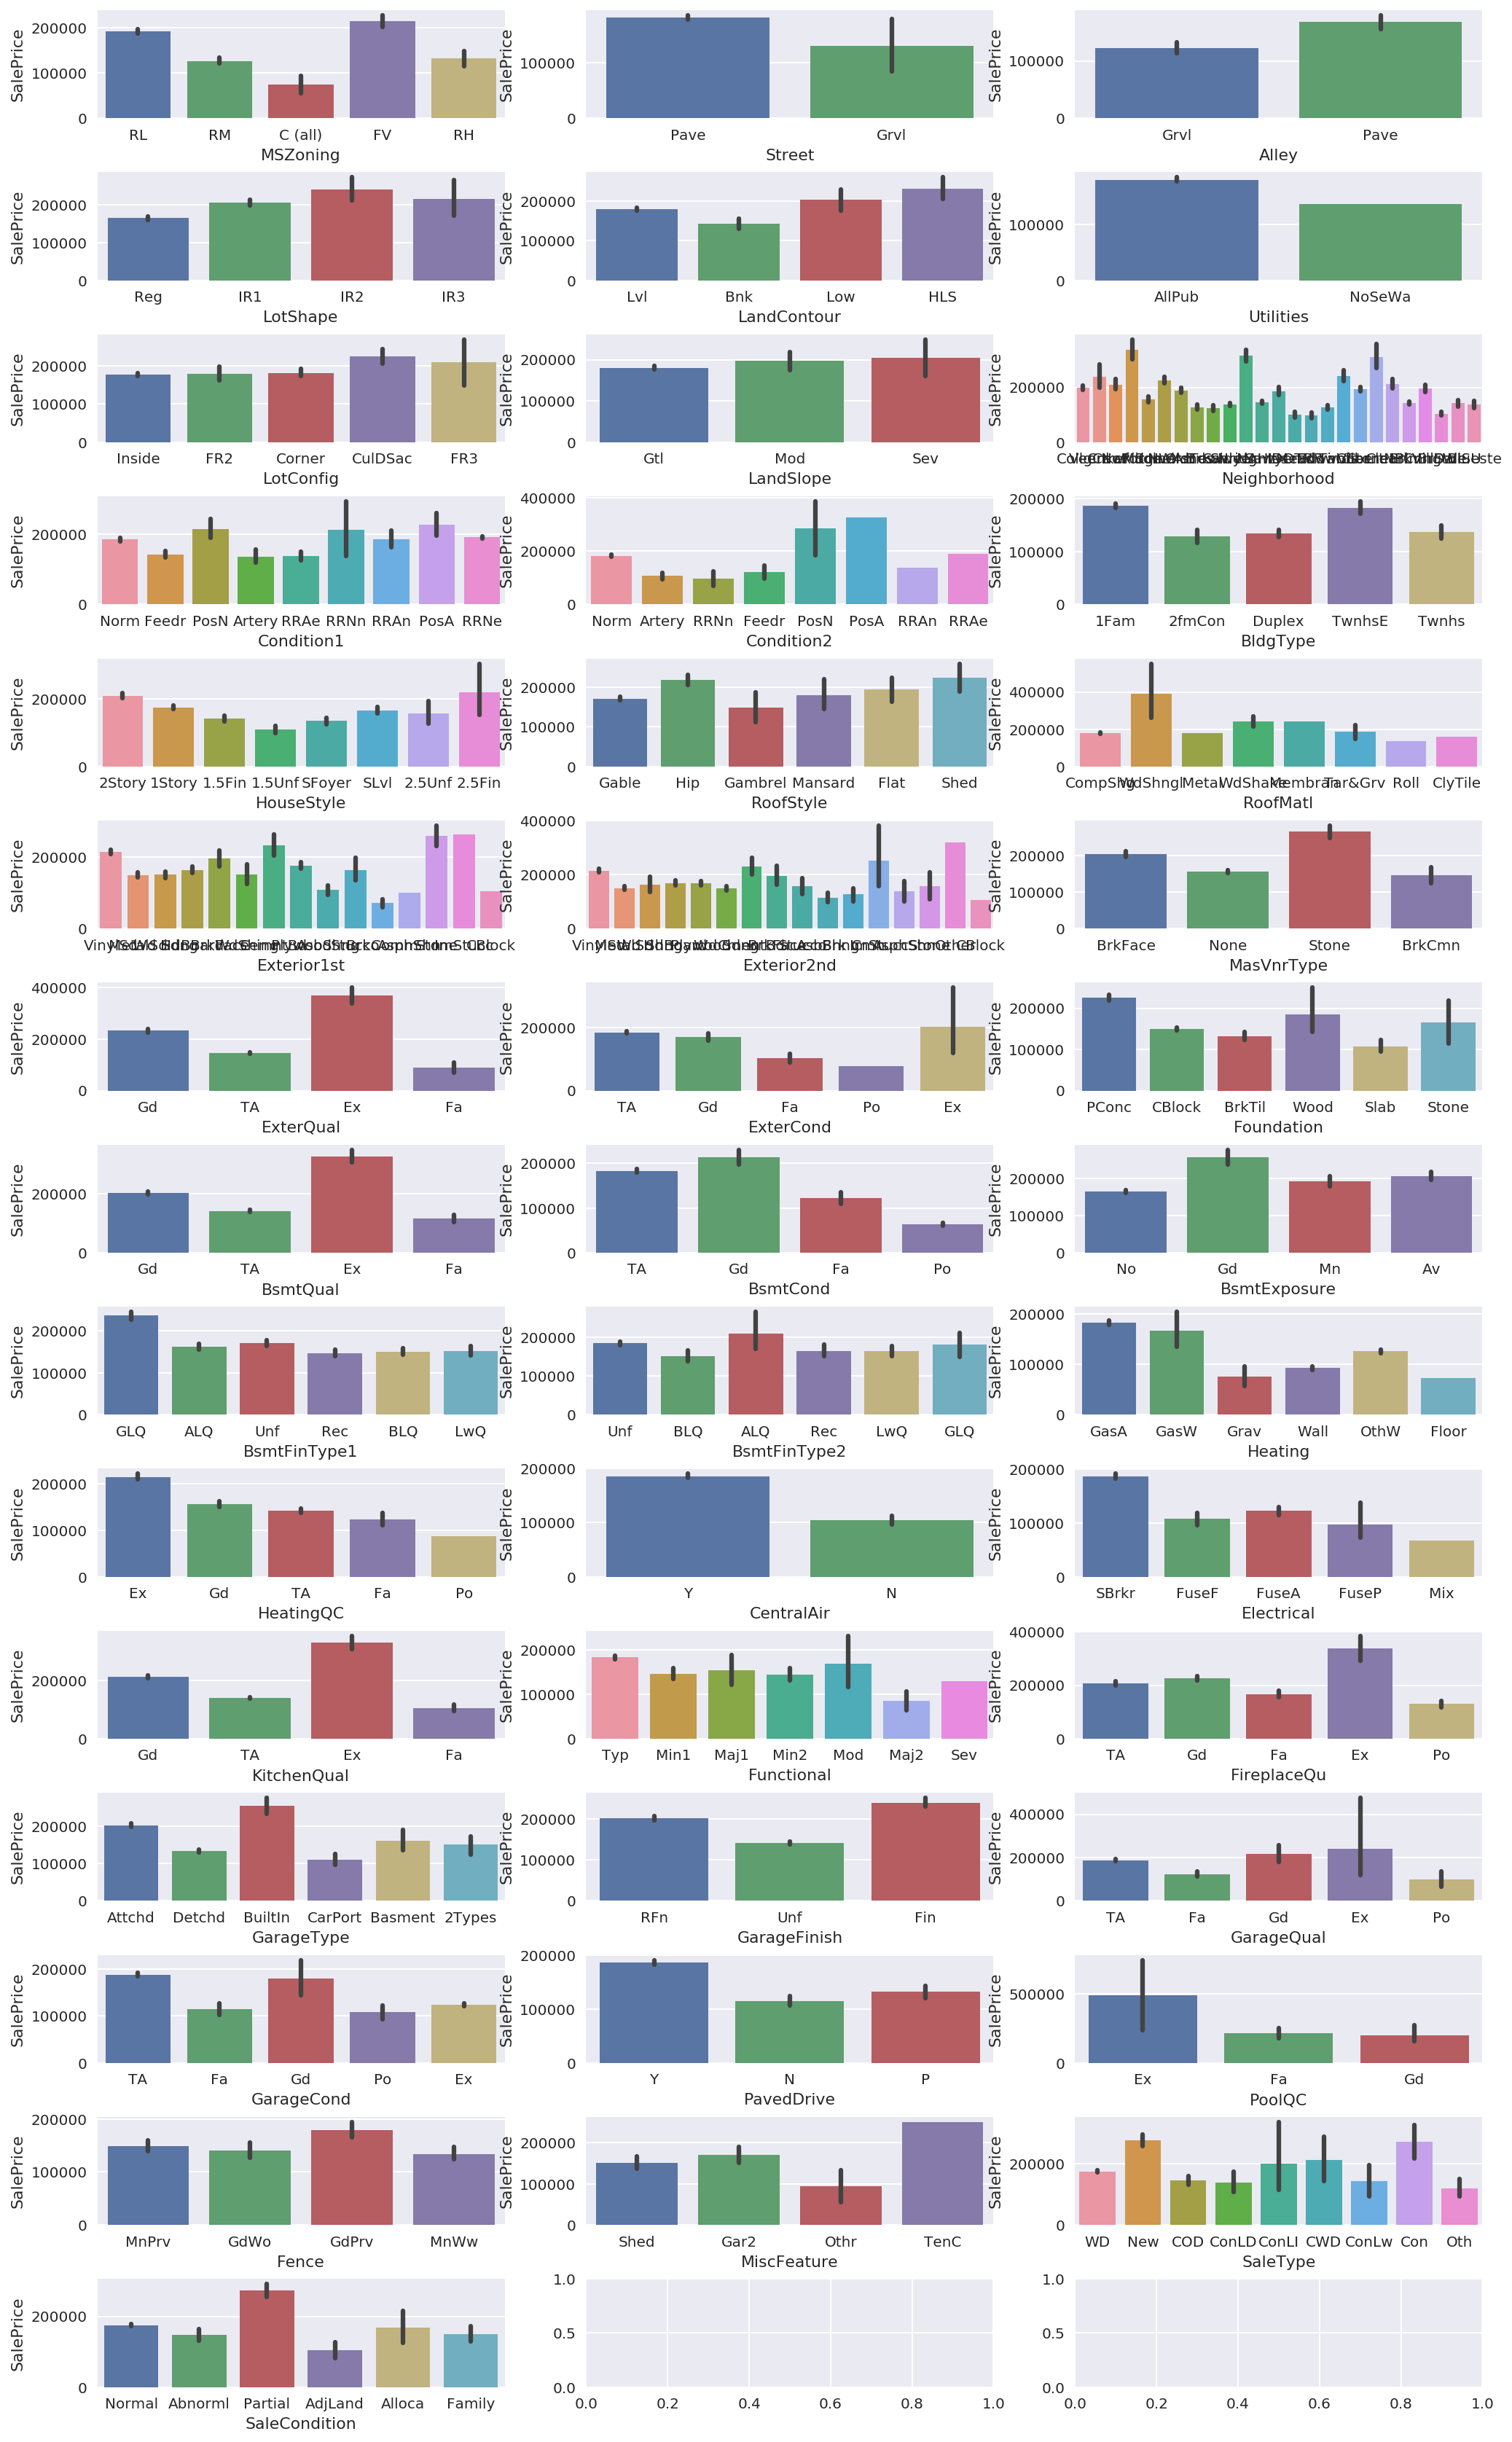

In [8]:
train_cat = train.select_dtypes(exclude=[np.number])
train_cat['SalePrice'] = train['SalePrice']

fig, axs = plt.subplots(15,3, figsize=(16, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2, right=0.95)

axs = axs.ravel()

for ind, feat in enumerate(train_cat.columns):
    if feat != 'SalePrice':
        sns.barplot(train_cat[feat], train_cat['SalePrice'], ax = axs[ind])

plt.show()

In [ ]:
# Categoric and Numerical 변수 분리
numerical_features = []
categorical_features = []
for f in train.columns:
    if train.dtypes[f] != 'object':
        numerical_features.append(f)
    else:
        categorical_features.append(f)

In [ ]:
print("Numerical Features Qty :", len(numerical_features),"\n")
print("Numerical Features : ", numerical_features, "\n\n")
print("Categorical Features Qty :", len(categorical_features),"\n")
print("Categorical Features :", categorical_features)

#### Numerical Features with SalePrice

In [ ]:
fig, ax = plt.subplots(20,2, figsize = (10,95))

for idx, n in enumerate(numerical_features):
    
    if idx % 2 == 0 :
        sns.regplot(x=n, y="SalePrice",data=train, ax = ax[idx//2,0])
    
        
    else:
        sns.regplot(x=n, y="SalePrice",data=train, ax = ax[idx//2,1])

In [ ]:
fig, ax = plt.subplots(22,2, figsize = (10,95))

for idx, n in enumerate(categorical_features):
    
    if idx % 2 == 0 :
        sns.countplot(x=n,data=train, ax = ax[idx//2,0])
  
    else:
        sns.countplot(x=n,data=train, ax = ax[idx//2,1])

## 2. Feature Engineering

### 2-1 SalePrice와 변수들 간의 관계

#### 2-1-1 GrLivArea  &  2ndFloor & Basement

In [ ]:
grid = sns.jointplot(x = "GrLivArea", y = "SalePrice", data=train, kind="reg")
grid.fig.set_size_inches(15,5)

df_train = train.copy()
df_train["2ndFloor"] = "2ndFloor"
df_train["2ndFloor"].loc[df_train["2ndFlrSF"]==0] = "No 2ndFloor"
df_train["Basement"] = "Basement"
df_train["Basement"].loc[df_train["TotalBsmtSF"]==0] = "No Basement"

plt.figure(figsize = (15,6))

plt.subplot(121)
g = sns.stripplot( x = "GrLivArea", y = 'SalePrice', hue = "2ndFloor", data = df_train, alpha = 0.7)
g.set_xlabel('GrLivArea')
g.set_ylabel('SalePrice')
g.set_ylim(0,400000)
g.set_title('GrLiv & 2ndFloor - SalePrice')

plt.subplot(122)
b = sns.stripplot( x = "GrLivArea", y = 'SalePrice', hue = "Basement", data = df_train, alpha = 0.7)
b.set_xlabel('GrLivArea')
b.set_ylabel('SalePrice')
g.set_ylim(0,400000)
g.set_title('GrLivArea & Basement - SalePrice')

plt.show()

In [ ]:
GrLivArea_outlier = detect_outliers(train, "GrLivArea")
GrLivArea_outlier

Find : 1. Grliv 넓이가 중간 아래부분까지는 같은 넓이의 집은 2층보다 1층집의 값 더 비싼것을 알수 있었다
       2. 베이스먼트가 없는집은 거의 없으며, 집값에는 영향이 없는것 같다 

#### 2-1-2 OverallQual & OverallCond

In [ ]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot2grid((2,2), (0,0), colspan = 2)
for qual in range(1,10+1):
    index = train.OverallQual == qual
    ax1.scatter(train.GrLivArea.loc[index], train.SalePrice.loc[index], data=train, label= qual, alpha =0.5)
ax1.legend(loc = 0)
ax1.set_title("GrLivArea & OverallQual - SalePrice")

ax2 = plt.subplot2grid((2,2), (1,0))
sns.boxplot(x = "OverallQual", y = "SalePrice", data=train, ax= ax2)
ax2.set_title('OverallQual - SalePrice')

ax3 = plt.subplot2grid((2,2), (1,1))
sns.boxplot(x = "OverallCond", y = "SalePrice", data=train, ax= ax3)
ax3.set_title('OverallCond - SalePrice')

In [ ]:
OverallQual_outlier = detect_outliers(train, "OverallQual")
OverallQual_outlier

Find : 1. 품질과 집값은 선형관계를 발견할 수 있으나 overall condition과 집값은 관계가 없는것을 발견할 수 있었음

#### 2-1-2 GarageArea & GarageCars

'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond'


In [ ]:
plt.figure(figsize=(15,6))

ax1 = plt.subplot(1,2,1)
for car in range(0,5):
    index = train.GarageCars == car
    ax1.scatter(x = train.GarageArea.loc[index], y = train.SalePrice.loc[index], data=train, label=car, alpha='0.5')

ax1.legend()
ax1.set_title('GarageArea - SalePrice')

ax2 = plt.subplot(1,2,2)
sns.stripplot(x = "GarageCars", y = "SalePrice", data=train,ax=ax2, jitter=True)
ax2.set_title('GarageCars - SalePrice')
ax2.legend()

plt.show()

In [ ]:
GarageCars_outlier = detect_outliers(train, "GarageArea")
GarageCars_outlier

#### 2-1-3 Neighborhood

In [ ]:
Neighbor = train.pivot_table(index="Neighborhood",values="SalePrice", aggfunc='mean').sort_values(by = ["SalePrice"], ascending = False)
Neighbor = Neighbor.reset_index()

In [ ]:
g = sns.factorplot(x = "Neighborhood", y="SalePrice", data=Neighbor, size =8, kind="bar")
g.set_xticklabels(rotation=45)
g.fig.set_size_inches(15,5)
plt.show()

In [ ]:
Neighbor_list=list(set(Neighbor["Neighborhood"]))

In [ ]:
High_price_neighbor = ['NoRidge','NridgHt','StoneBr']
Middle_price_neighbor = ['Timber','Somerst','Veenker','ClearCr','Crawfor','NWAmes', 'Gilbert','Blmngtn', 'SWISU','Mitchel','CollgCr']
Low_price_neighbor = ['IDOTRR','Blueste', 'Sawyer','NAmes', 'BrDale', 'OldTown','MeadowV', 'NPkVill','BrkSide','Edwards']

In [ ]:
# def Gp_Neighbor(saleprice):
#     if saleprice > 250000:
#         return "first_group"
#     elif saleprice > 200000:
#         return "second_group"
#     elif saleprice > 150000:
#         return "third_group"
#     else: 
#         return "fourth_group"

In [ ]:
# for n in Neighbor_list:
#     if n in High_price_neighbor:
#         High_price.append(n)
#     train[train["Neighborhood"] == n

# High_price_neighbor = train[train["Neighborhood"] == 'NoRidge','NridgHt','StoneBr'

In [ ]:
# df_train = train.copy()
# df_train["Gp_Neighborhood"] = train["SalePrice"].apply(Gp_Neighborhood)
# g = sns.factorplot(x="Gp_Neighborhood", y="SalePrice", data=train, kind="bar")
# g.fig.set_size_inches(15,5)
# plt.show()

#### 2-1-4 YearBuilt

'YearBuilt', 'YearRemodAdd',

In [ ]:
plt.figure(figsize=(15,6))
fig = sns.boxplot(x="YearBuilt", y="SalePrice", data=train)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,6))
ax2 = plt.subplot(1,2,1)
ax2.scatter(x = train['YearBuilt'], y = train['YearRemodAdd'], alpha = 0.5)
ax3 = plt.subplot(1,2,2)
ax3.scatter(x = train['YearBuilt'], y = train['YrSold'], alpha = 0.5)
plt.show()

plt.figure(figsize=(15,6))
ax4 = plt.subplot2grid((2,2), (0,0), colspan = 2)
ax4.scatter(x = train['YearBuilt'], y = train['OverallQual'], alpha = 0.5)
ax5 = plt.subplot2grid((2,2), (1,0), colspan = 2)
sns.countplot(x = "MoSold", data=train, ax = ax5)
plt.show()

Find

1.

#### 2-1-5 Fireplaces & FireplaceQu

In [ ]:
plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((2,2), (0,0), colspan = 2)
sns.stripplot(x = train['Fireplaces'], y = train['SalePrice'], alpha = 0.5, jitter = True, ax=ax1)

ax2 = plt.subplot2grid((2,2), (1,0))
sns.countplot(x = "FireplaceQu", data=train, ax = ax2, order = train["FireplaceQu"].value_counts().index)

ax3 = plt.subplot2grid((2,2), (1,1))
sns.boxplot(x = 'FireplaceQu', y = 'OverallQual', data = train, ax=ax3)
plt.show()

plt.figure(figsize=(15,10))
ax4 = plt.subplot(2,1,1)
sns.stripplot(x='FireplaceQu', y='SalePrice', hue='Fireplaces', data=train, jitter=True, alpha=0.6, ax=ax4)

ax5 = plt.subplot(2,1,2)
ax5.scatter(x = train['Fireplaces'], y = train['GrLivArea'], alpha = 0.5)
plt.show()


Find

1.

#### 2-1-6 BsmtBath

BsmtFullBath : 지하실 가득한 욕실  
BsmtHalfBath : 지하 욕실 반 화장실

BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',

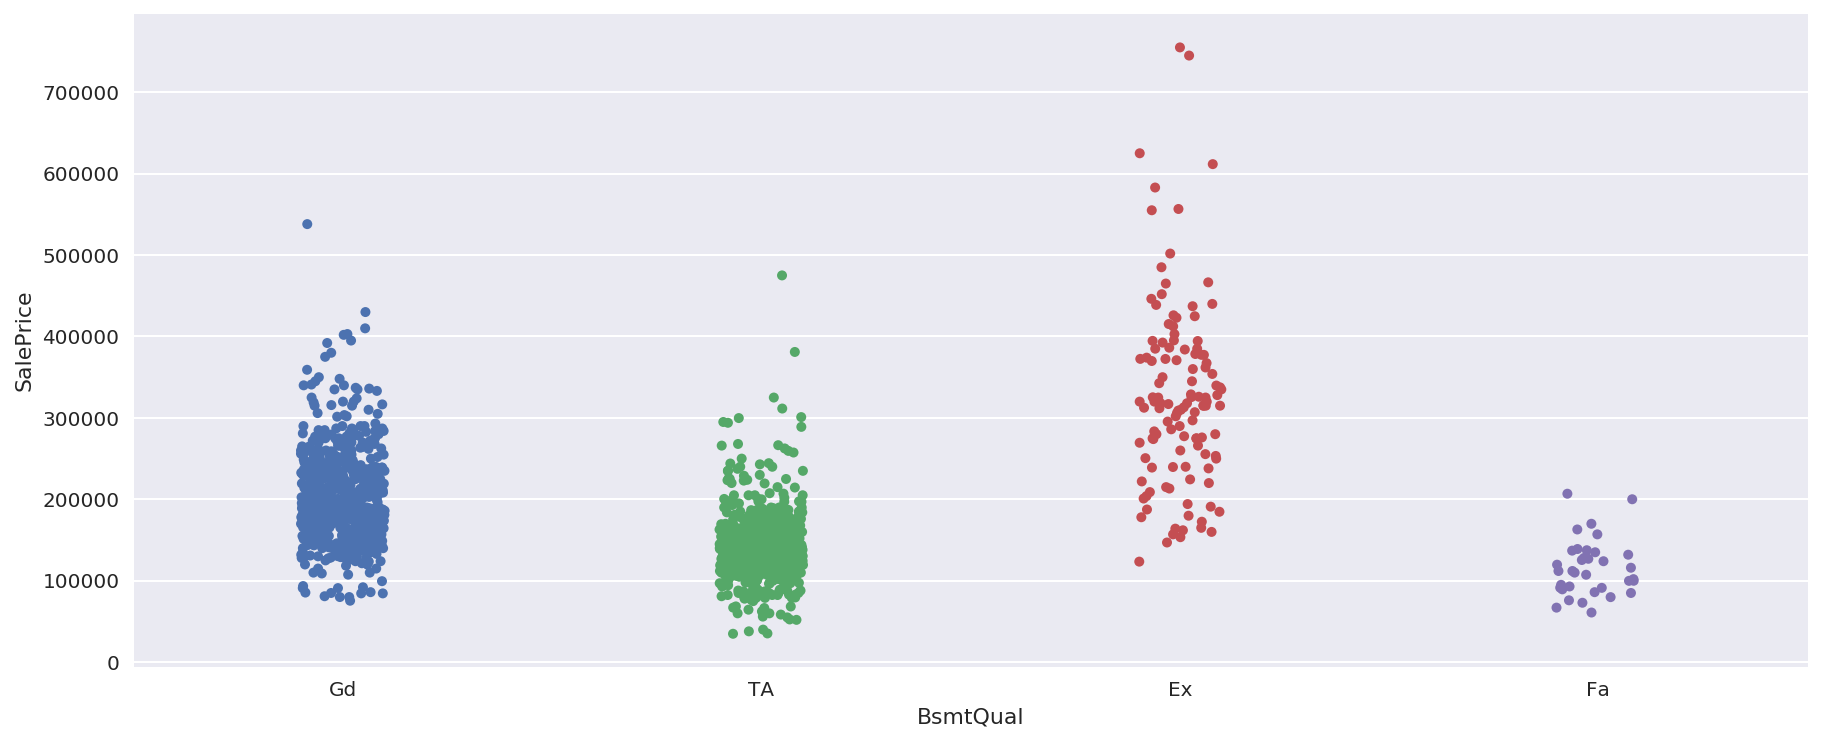

In [4]:
plt.figure(figsize=(15,6))
sns.stripplot(x = "BsmtQual", y = "SalePrice", data=train, jitter=True)
plt.show()

No handles with labels found to put in legend.


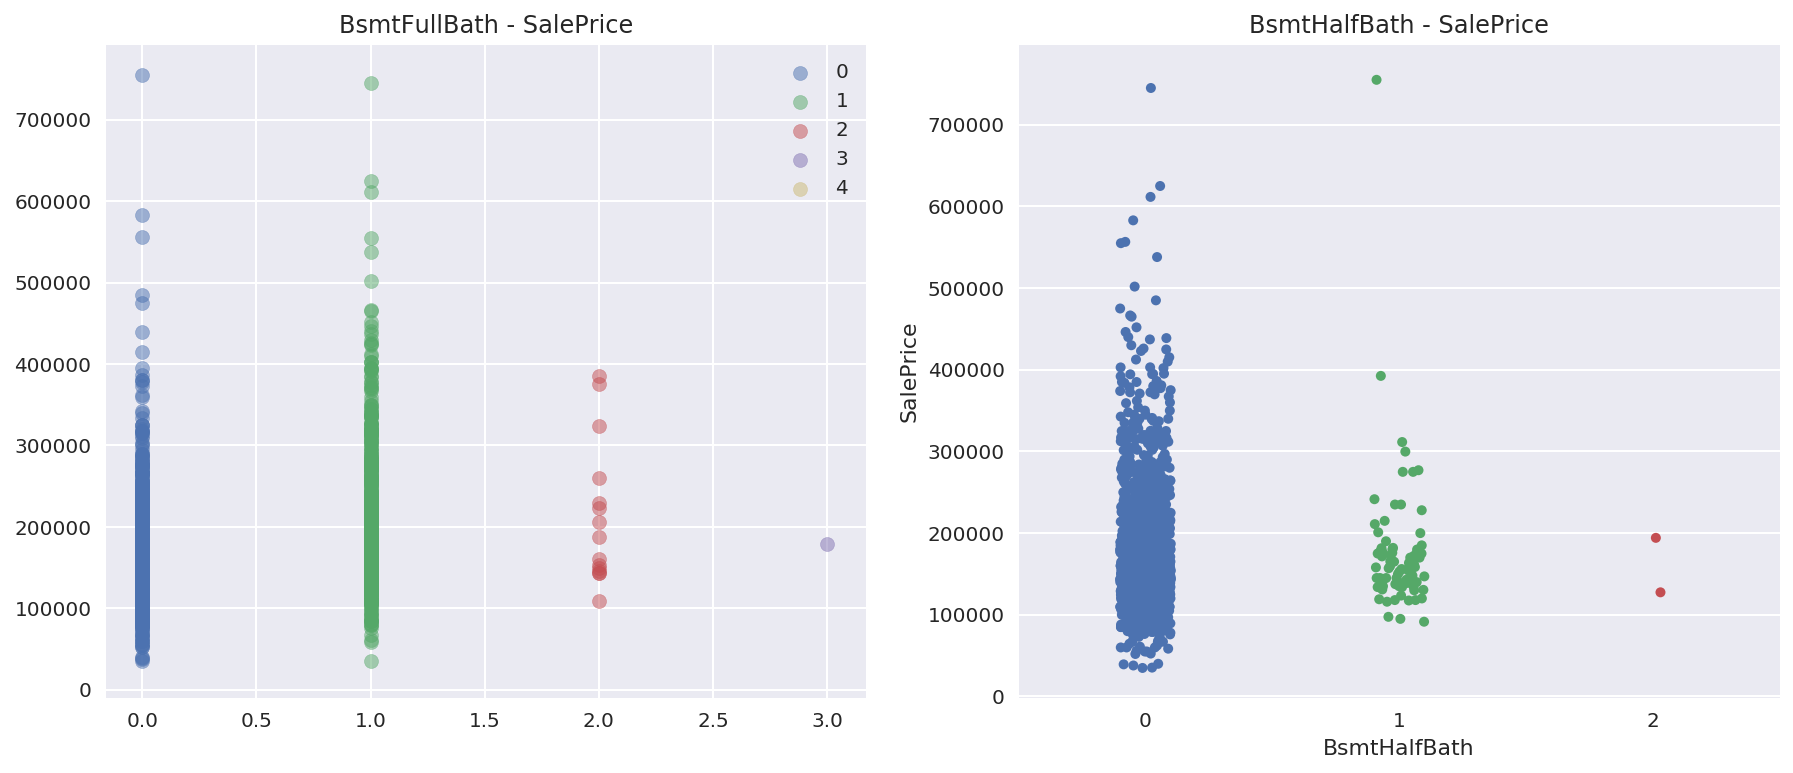

In [5]:
plt.figure(figsize=(15,6))

ax1 = plt.subplot(1,2,1)
for BSMT in range(0,5):
    index = train.BsmtFullBath == BSMT
    ax1.scatter(x = train.BsmtFullBath.loc[index], y = train.SalePrice.loc[index], data=train, label=BSMT, alpha='0.5')

ax1.legend()
ax1.set_title('BsmtFullBath - SalePrice')

ax2 = plt.subplot(1,2,2)
sns.stripplot(x = "BsmtHalfBath", y = "SalePrice", data=train,ax=ax2, jitter=True)
ax2.set_title('BsmtHalfBath - SalePrice')
ax2.legend()

# ax3 = plt.subplot(2,1,2)
# ax = sns.countplot(x="BsmtHalfBath", data=train,
#                     facecolor=(0, 0, 0, 0),
#                     linewidth=5,
#                     edgecolor=sns.color_palette("dark", 3))

# ax3 = plt.subplot(2,1,1)
# sns.countplot(x= "SalePrice", hue="BsmtHalfBath", data=train, ax=ax3)

# plt.show()



# plt.subplot(121)
# sns.boxplot(x = "BsmtFullBath", y = "SalePrice", data=train)

# plt.subplot(122)
# sns.boxplot(x = "BsmtHalfBath", y = "SalePrice", data=train)

BsmtFUllBATH의 경우에는 최소값에 영향을 주고 & HalfBath 의 경우에는 salprice에 큰 영향을 주지 않는 것으로 보인다.

In [ ]:
# test = np.log1p(train.BsmtFullBath)
# stats.probplot(test, plot=plt)
# stats.probplot(train["BsmtFullBath"], plot=plt)
# stats.probplot(train["BsmtHalfBath"], plot=plt)

In [ ]:
#stats.probplot(train["BsmtFullBath"], plot=plt)

#### 2-1-7 TotRm and Bedroom

In [ ]:
# plt.figure(figsize=(15,10))
# ax1 = plt.subplot2grid((2,2), (0,0), colspan = 2)
# sns.stripplot(x = train['TotRmsAbvGrd'], y = train['SalePrice'], alpha = 0.5, jitter = True, ax=ax1)

plt.figure(figsize=(15,10))
ax1 = plt.subplot(2,1,1)
sns.stripplot(x='TotRmsAbvGrd', y='SalePrice', hue='TotRmsAbvGrd', data=train, jitter=True, alpha=0.6, ax=ax1)

ax2 = plt.subplot2grid((2,2), (1,0))
sns.countplot(x = "TotRmsAbvGrd", data=train , ax = ax2, order = train["TotRmsAbvGrd"].value_counts().index)

ax3 = plt.subplot2grid((2,2), (1,1))
sns.boxplot(x = 'TotRmsAbvGrd', y = 'OverallQual', data = train, ax=ax3)
plt.show()

grid = sns.jointplot(x = "TotRmsAbvGrd", y = "SalePrice", data=train, kind="reg", size = 10)

# ax5 = plt.subplot(2,1,2)
# ax5.scatter(x = train['Fireplaces'], y = train['GrLivArea'], alpha = 0.5)
# plt.show()


In [ ]:
plt.figure(figsize=(15,6))

ax1 = plt.subplot(1,2,1)
for TotRmsAbvGrd in range(0,5):
    index = train.TotRmsAbvGrd == TotRmsAbvGrd
    sns.stripplot(x = train.BsmtFullBath, y = train.SalePrice, data=train,ax = ax1, label=TotRmsAbvGrd, alpha='0.5')

ax1.legend()
ax1.set_title('TotRmsAbvGrd - SalePrice')

ax2 = plt.subplot(1,2,2)
sns.stripplot(x = "BedroomAbvGr", y = "SalePrice", data=train,ax=ax2, jitter=True)
ax2.set_title('BedroomAbvGr - SalePrice')
ax2.legend()

grid = sns.jointplot(x = "BedroomAbvGr", y = "SalePrice", data=train, kind="reg", size = 10)


plt.show()

# plt.subplot(121)
# sns.boxplot(x = "TotRmsAbvGrd", y = "SalePrice", data=train)

# plt.subplot(122)
# sns.boxplot(x = "BedroomAbvGr", y = "SalePrice", data=train)

확실히 TotRmsAbvGrd 는 연관관계가 있는것으로 보임

In [ ]:
stats.probplot(train["TotRmsAbvGrd"], plot=plt)
stats.probplot(train["BedroomAbvGr"], plot=plt)

In [ ]:
train[['TotRmsAbvGrd', 'BedroomAbvGr']].hist(bins=80, figsize=(10,5))

Tot : 길게 하나 하고, 어떤 방이 여기에 포함되어있는지 확인필요

이런 데이터의 경우에는 확실히 한단계 데이터 조치가 필요할것으로 보임
이런 경우는 어떻게 해야하지?

Full Bath의 경우에는 영향이 있으나 HalfBath의 경우에는 영향이 미미한것으로 확인할 수 있음

### 2-2 Missing Data 처리

3가지 정도의 가설 
1. 미싱데이터 80% 이상의 데이터들을 제거했을때
2. 비어있는 값들의 처리를 0 or mean 값으로 한경우
3. one-hot encoding 했을때 

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("All data size is {}".format(all_data.shape))

All data size is (2919, 80)


In [ ]:
total = all_data.isnull().sum().sort_values(ascending=False)
ratio = ((all_data.isnull().sum()/len(all_data))*100).sort_values(ascending=False)
missing_data = pd.concat([total, ratio], axis=1, keys=['Total', 'Ratio'])
missing_data[:20]

In [ ]:
f, ax = plt.subplots(figsize=(15,7))
plt.xticks(rotation='45')
sns.barplot(x=ratio.index, y=ratio)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing valurs', fontsize=15)
plt.title('Percent missing data by features', fontsize=15)

In [ ]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

# Missing value 제거시 

In [ ]:
# all_data.drop("PoolQC", axis = 1, inplace = True)
# all_data.drop("MiscFeature", axis = 1, inplace = True)
# all_data.drop("Alley", axis = 1, inplace = True)

# missing value 채우기 

In [ ]:
train.columns

방법 1

In [ ]:
feats=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for feat in feats:
    all_data[feat].fillna(0, inplace=True)

In [ ]:
# fill in with None
feats1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for feat in feats1:
    all_data[col].fillna("None", inplace=True)

In [ ]:
# fill in with mode
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for feat in feats2:
    full[col].fillna(full[col].mode()[0], inplace=True)

방법 2

In [ ]:
# NA means no fence 로 생각하고 데이터 케어
all_data["Fence"].fillna("None", inplace=True)

# FireplaceQu  NA 값을 Fireplace 가 없는 것으로 생각하고 제어
All_data["FireplaceQu"].fillna("None", inplace=True)

#  GarageCond 
## NA garage 가 없다는 것을 의미
All_data["GarageCond"].fillna("None", inplace=True)

# GarageFinish 
## NA garage 가 없다는 것을 의미
All_data["GarageFinish"].fillna("None", inplace=True)

# GarageQual 
## NA garage 가 없다는 것을 의미
All_data["GarageQual"].fillna("None", inplace=True)

# GarageType 
## NA garage 가 없다는 것을 의미
All_data["GarageType"].fillna("None", inplace=True)

# BsmtFinType2 
# na는 basement 가 없다는것을 의미
All_data["BsmtFinType2"].fillna("None", inplace=True)

# BsmtExposure
# na는 basement 가 없다는것을 의미
All_data["BsmtExposure"].fillna("None", inplace=True)

# BsmtQual
# na는 basement 가 없다는것을 의미
All_data["BsmtQual"].fillna("None", inplace=True)

# BsmtFinType1
# na는 basement 가 없다는것을 의미
All_data["BsmtFinType1"].fillna("None", inplace=True)

# BsmtCond:
# na는 basement 가 없다는것을 의미
All_data["BsmtCond"].fillna("None", inplace=True)

# MasVnrType:
# 말그대로 none 
All_data["MasVnrType"].fillna("None", inplace=True)

# MasVnrArea 
# 0에 가깝다는 것을 의미 
All_data["MasVnrArea"].fillna(0, inplace=True) 

### Electrical !!!
# 일단은 가장 많은값인 SKrkr을 넣어주었음
All_data["Electrical"].fillna("SBrkr", inplace=True) 

# BsmtHalfBath 
# 0에 가깝다는 것을 의미 
All_data["BsmtHalfBath"].fillna(0, inplace=True)

# BsmtFullBath
# 0에 가깝다는 것을 의미 
All_data["BsmtFullBath"].fillna(0, inplace=True)

# BsmtFinSF1 
# 0에 가깝다는 것을 의미 
All_data["BsmtFinSF1"].fillna(0, inplace=True)

# BsmtFinSF2 
# 0에 가깝다는 것을 의미 
All_data["BsmtFinSF2"].fillna(0, inplace=True)

# BsmtUnfSF 
# 0에 가깝다는 것을 의미 
All_data["BsmtUnfSF"].fillna(0, inplace=True)

# TotalBsmtSF
# 0에 가깝다는 것을 의미 
All_data["TotalBsmtSF"].fillna(0, inplace=True)

# GarageCars
# 0
All_data["GarageCars"].fillna(0, inplace=True)

## GarageArea 
# 0
#All_data["GarageArea"].fillna(0, inplace=True)

# Utilities 
# 
All_data["Utilities"].fillna(0, inplace=True)

# BsmtCond:
# 
All_data["Functional"].fillna(0, inplace=True)

# BsmtCond
# KitchenQual 0? none?
All_data["KitchenQual"].fillna(0, inplace=True)

#MSZoning  !!!!!!!!!!!!!! 어떻게 처리해야할지
All_data["MSZoning"].fillna("", inplace=True)

#SaleType 
# 가장 빈도수가 많은 값을 넣어줌 
All_data["SaleType"].fillna("WD", inplace=True)

#Exterior 1 and 2 :
 # 가장 빈도수가 많은 값을 넣어줌 

All_data['Exterior1st'] = All_data['Exterior1st'].fillna(All_data['Exterior1st'].mode()[0])
All_data['Exterior2nd'] = All_data['Exterior2nd'].fillna(All_data['Exterior2nd'].mode()[0])



Exterior1st        1  
Exterior2nd        1

#MSZoning  !!!!!!!!!!!!!! 어떻게 처리해야할지

#MSSubClass 데이터 처리 방안... 유사 근접?


In [ ]:
# 숫자로 된 카테고리 데이터들로 변경 

Changed_data = all_data.replace({"BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"None" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageFinish" : {"None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
                       "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [ ]:
# 숫자로 된 카테고리 데이터들로 변경 
neighborhood 데이터 범주화 


해결 못한것 : 

In [ ]:
# 카테고리 데이터 수치화 
Changed_data = Changed_data.replace({"MSSubClass" : {},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                  7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                                    })


방법3 비슷한데이터들은 비슷한 처리방법으로 

In [ ]:
for feat in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[feat] = all_data[feat].fillna('None')

for feat in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[feat] = all_data[feat].fillna(0)

for feat in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[feat] = all_data[col].fillna(0)

# category 데이터 이므로 none 값으로 채워준다. 
for feat in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[feat] = all_data[feat].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning']= all_data["MSZoning"].fillna(all_data['MSZoning'].mode()[0])

# 이용하기 애매해서 여기선 drop 함 
all_data = all_data.drop('Utilities', axis=1)

all_data['Functional']= all_data["Functional"].fillna("Typ")

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))


all_data["Electrical"] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data["KitchenQual"]=all_data["KitchenQual"].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

missing data 확인하는곳

In [12]:
all_data.isnull().sum()[all_data.isnull().sum()>0]

Alley           2721
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2348
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2814
PoolQC          2909
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

### 2-3 아웃라이어 제거

In [ ]:
y_train

In [ ]:
# 데이터 븐류 
train = all_data[:ntrain]
test = all_data[ntrain:]

In [ ]:
x_train_x0 = train.copy()

In [ ]:
x_train = sm.add_constant(x_train_x0)
x_train = pd.get_dummies(x_train)

In [ ]:
x_train.tail()

In [ ]:
x_train = pd.DataFrame(x_train.astype(float))
y_train = pd.DataFrame(y_train.astype(float))

x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
model = sm.OLS(pd.DataFrame(y_train),pd.DataFrame(x_train))
result = model.fit()
print(result.summary())

In [ ]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(15,6))
plt.stem(hat)
plt.show()

In [ ]:
hat.sum()

In [ ]:
plt.figure(figsize=(15, 6))
plt.stem(result.resid_pearson)
plt.show()

In [ ]:
g = sm.graphics.plot_leverage_resid2(result)
g.set_size_inches(15,5)
plt.show()

In [ ]:
idx = result.resid_pearson < 2
x_train = x_train[idx]
y_train = y_train[idx]

### Encoding

In [ ]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
categoric_encoded = []
for q in categoric_features:  
    encode(train, q)
    categoric_encoded.append(q+'_E')
print(categoric_encoded)

In [ ]:
corrmat = train.corr()
corrmat

In [ ]:
import missingno as msno

missingValueColumns = train.columns[train.isnull().any()].tolist()
msno.heatmap(train[missingValueColumns],figsize=(20,20))

In [ ]:
cols = corrmat.nlargest(30, 'SalePrice')['SalePrice'].index
cols

In [ ]:
f, ax = plt.subplots(figsize = (15,9))
sns.heatmap(corrmat, vmax = 1, square=True)

In [ ]:
cols = corrmat.nlargest(20, 'SalePrice')['SalePrice'].index 
cols

In [ ]:
cm = np.corrcoef(train[cols].values.T)

plt.figure(figsize=(20,20))
sns.set(font_scale=1.25)
hm=sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',\
              annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.plot()

In [ ]:
for c in cols:
    data = pd.concat([train['SalePrice'], train[c]],axis=1)
    data.plot.scatter(x=c, y='SalePrice',ylim=(0,800000));

In [ ]:
# all_data[(all_data['GarageCars']==4) & (all_data['SalePrice'] < 300000)]

In [ ]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [ ]:
from scipy import stats
from scipy.stats import norm, skew

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(30)

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])